<a href="https://colab.research.google.com/github/sam505/Machine_Learning/blob/master/PYTORCH_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import io
import PIL.Image
import torch.nn as nn
from torch import optim
import torch.utils.data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

train_batch_size = 64
test_batch_size = 128

mnist_train = torchvision.datasets.MNIST(root="~/", 
                                         download=True, 
                                         transform=transform, 
                                         train=True)

mnist_test = torchvision.datasets.MNIST(root="~/", 
                                        download=True, 
                                        transform=transform, 
                                        train=False)

train_loader = torch.utils.data.DataLoader(mnist_train,
                                          shuffle=True,
                                          batch_size=train_batch_size,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          shuffle=False,
                                          batch_size=test_batch_size,
                                          num_workers=2)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/MNIST/raw/train-images-idx3-ubyte.gz to /root/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/MNIST/raw/train-labels-idx1-ubyte.gz to /root/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(mnist_train)

60000

In [4]:
len(mnist_test)

10000

In [5]:
learning_rates = [0.001, 0.01, 0.1]

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [7]:
def train(model, optimizer, epoch, train_loader, log_interval):
    # State that you are training the model
    model.train()
    correct = 0
    count = 1
    # define loss function
    loss_fn = nn.CrossEntropyLoss()

    # Iterate over batches of data
    for batch_idx, (data, target) in enumerate(train_loader):
        # Wrap the input and target output in the `Variable` wrapper
        data, target = Variable(data), Variable(target)

        check_gpu = torch.cuda.is_available()
        if check_gpu:
            data = data.to("cuda")
            target = target.to("cuda")

        # Clear the gradients, since PyTorch accumulates them
        optimizer.zero_grad()

        # Forward propagation
        output = model(data)

        loss = loss_fn(output, target)

        # Backward propagation
        loss.backward()

        # Update the parameters(weight,bias)
        optimizer.step()
        
        predicted = torch.max(output.data, 1)[1] 
        correct += (predicted == target).sum()

        # print log
        if batch_idx % log_interval == 0:
            train_accuracy = correct / ((batch_idx+1)*len(data))
            train_loss = loss.data.item()
            print('Train set, Epoch {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                train_loss, train_accuracy))
        
    return loss.data.item(), train_accuracy

In [8]:
def test(model, epoch, test_loader):
    # State that you are testing the model; this prevents layers e.g. Dropout to take effect
    model.eval()

    # Init loss & correct prediction accumulators
    test_loss = 0
    correct = 0

    # define loss function
    loss_fn = nn.CrossEntropyLoss(size_average=False)

    # Iterate over data
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)

        check_gpu = torch.cuda.is_available()
        if check_gpu:
            data = data.to("cuda")
            target = target.to("cuda")

        # Forward propagation
        output = model(data)

        # Calculate & accumulate loss
        test_loss += loss_fn(output, target).data.item()

        # Get the index of the max log-probability (the predicted output label)
        pred = np.argmax(output.cpu().data, axis=1)

        # If correct, increment correct prediction accumulator
        correct = correct + np.equal(pred, target.cpu().data).sum()

    # Print log
    test_loss /= len(test_loader.dataset)
    print('\nTest set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [9]:
# Provide seed for the pseudorandom number generator s.t. the same results can be reproduced
for learning_date in learning_rates:
    torch.manual_seed(123)

    model = LeNet()

    check_gpu = torch.cuda.is_available()
    if check_gpu:
        model = model.cuda()
        print ('USING GPU')
    else:
        print ('USING CPU')
    epochs = 10
    log_interval = 100
    writer = SummaryWriter("runs/Mnist_Adam_{}".format(learning_date))
    optimizer = optim.Adam(model.parameters(), lr=learning_date)
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, optimizer, epoch, train_loader, log_interval=log_interval)
        test_loss, test_acc = test(model, epoch, test_loader) 
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/test', test_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/test', test_acc, epoch)

USING GPU
Train set, Epoch 1 [0/60000 (0%)]	Loss: 2.302851	Accuracy: 0.20
Train set, Epoch 1 [6400/60000 (11%)]	Loss: 0.236700	Accuracy: 0.67
Train set, Epoch 1 [12800/60000 (21%)]	Loss: 0.127259	Accuracy: 0.79
Train set, Epoch 1 [19200/60000 (32%)]	Loss: 0.223787	Accuracy: 0.84
Train set, Epoch 1 [25600/60000 (43%)]	Loss: 0.144445	Accuracy: 0.87
Train set, Epoch 1 [32000/60000 (53%)]	Loss: 0.185666	Accuracy: 0.89
Train set, Epoch 1 [38400/60000 (64%)]	Loss: 0.111824	Accuracy: 0.90
Train set, Epoch 1 [44800/60000 (75%)]	Loss: 0.093752	Accuracy: 0.91
Train set, Epoch 1 [51200/60000 (85%)]	Loss: 0.013772	Accuracy: 0.92
Train set, Epoch 1 [57600/60000 (96%)]	Loss: 0.098341	Accuracy: 0.92


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set, Epoch 1 , Average loss: 0.0637, Accuracy: 9787/10000 (97.87%)

Train set, Epoch 2 [0/60000 (0%)]	Loss: 0.042930	Accuracy: 0.98
Train set, Epoch 2 [6400/60000 (11%)]	Loss: 0.085314	Accuracy: 0.97
Train set, Epoch 2 [12800/60000 (21%)]	Loss: 0.025390	Accuracy: 0.98
Train set, Epoch 2 [19200/60000 (32%)]	Loss: 0.046441	Accuracy: 0.98
Train set, Epoch 2 [25600/60000 (43%)]	Loss: 0.080409	Accuracy: 0.98
Train set, Epoch 2 [32000/60000 (53%)]	Loss: 0.035033	Accuracy: 0.98
Train set, Epoch 2 [38400/60000 (64%)]	Loss: 0.102935	Accuracy: 0.98
Train set, Epoch 2 [44800/60000 (75%)]	Loss: 0.066413	Accuracy: 0.98
Train set, Epoch 2 [51200/60000 (85%)]	Loss: 0.103698	Accuracy: 0.98
Train set, Epoch 2 [57600/60000 (96%)]	Loss: 0.007097	Accuracy: 0.98

Test set, Epoch 2 , Average loss: 0.0478, Accuracy: 9852/10000 (98.52%)

Train set, Epoch 3 [0/60000 (0%)]	Loss: 0.111525	Accuracy: 0.97
Train set, Epoch 3 [6400/60000 (11%)]	Loss: 0.025757	Accuracy: 0.98
Train set, Epoch 3 [12800/60000 (21%

In [13]:
import random

for data, target in test_loader:
    index = random.randint(0, len(data))
    data, target = Variable(data), Variable(target)
    img = data[index]
    if check_gpu:
      img = img.to("cuda")
    img=img.unsqueeze(0)
    print(img.size())
    break

torch.Size([1, 1, 28, 28])


In [14]:
no_of_layers=0
conv_layers=[]

model_children=list(model.children())

for child in model_children:
    if type(child)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(child)
    elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)
                
print(no_of_layers)

2


In [15]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [18]:
def save_plot(plot_buf):
    image = PIL.Image.open(plot_buf)
    image = ToTensor()(image).unsqueeze(0)
    image = image.reshape(3, 288, 432)


    writer = SummaryWriter(comment='Feature Map')
    #x = torchvision.utils.make_grid(image, normalize=True, scale_each=True)
    for n_iter in range(100):
        if n_iter % 10 == 0:
            writer.add_image('Image', image, n_iter)

def gen_plot():
    """Create a pyplot plot and save to buffer."""
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(50, 10))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print("Layer ",num_layer+1)
        for i, filter in enumerate(layer_viz):
            if i == 20: 
                break
            plt.subplot(2, 8, i + 1)
            plt.title("Layer {}".format(num_layer+1))
            plt.imshow(filter.cpu(), cmap='gray')
            plt.axis("off")  
        plt.show()
        buf = io.BytesIO()
        plt.savefig(buf, format='jpeg')
        buf.seek(0)
        save_plot(buf)

Layer  1


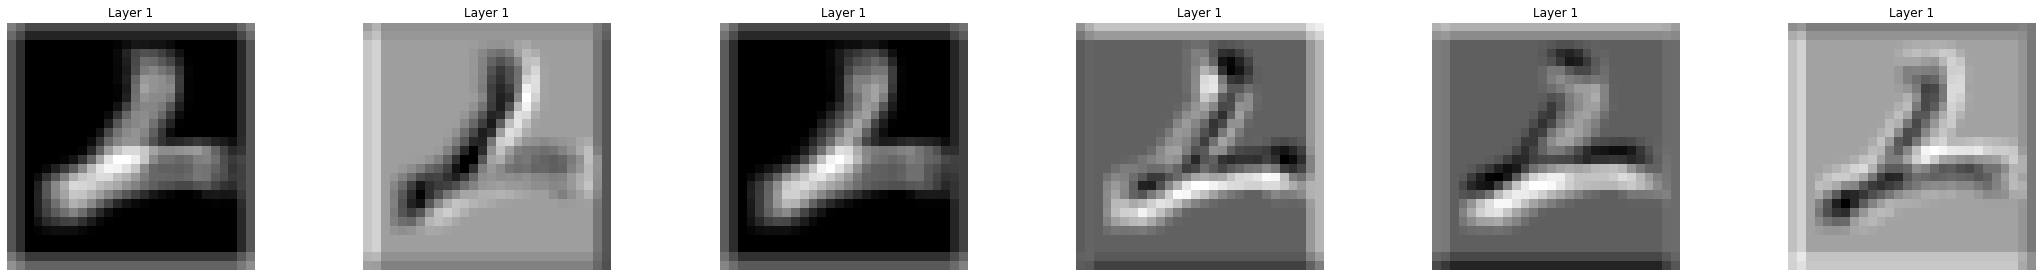

Layer  2


<Figure size 432x288 with 0 Axes>

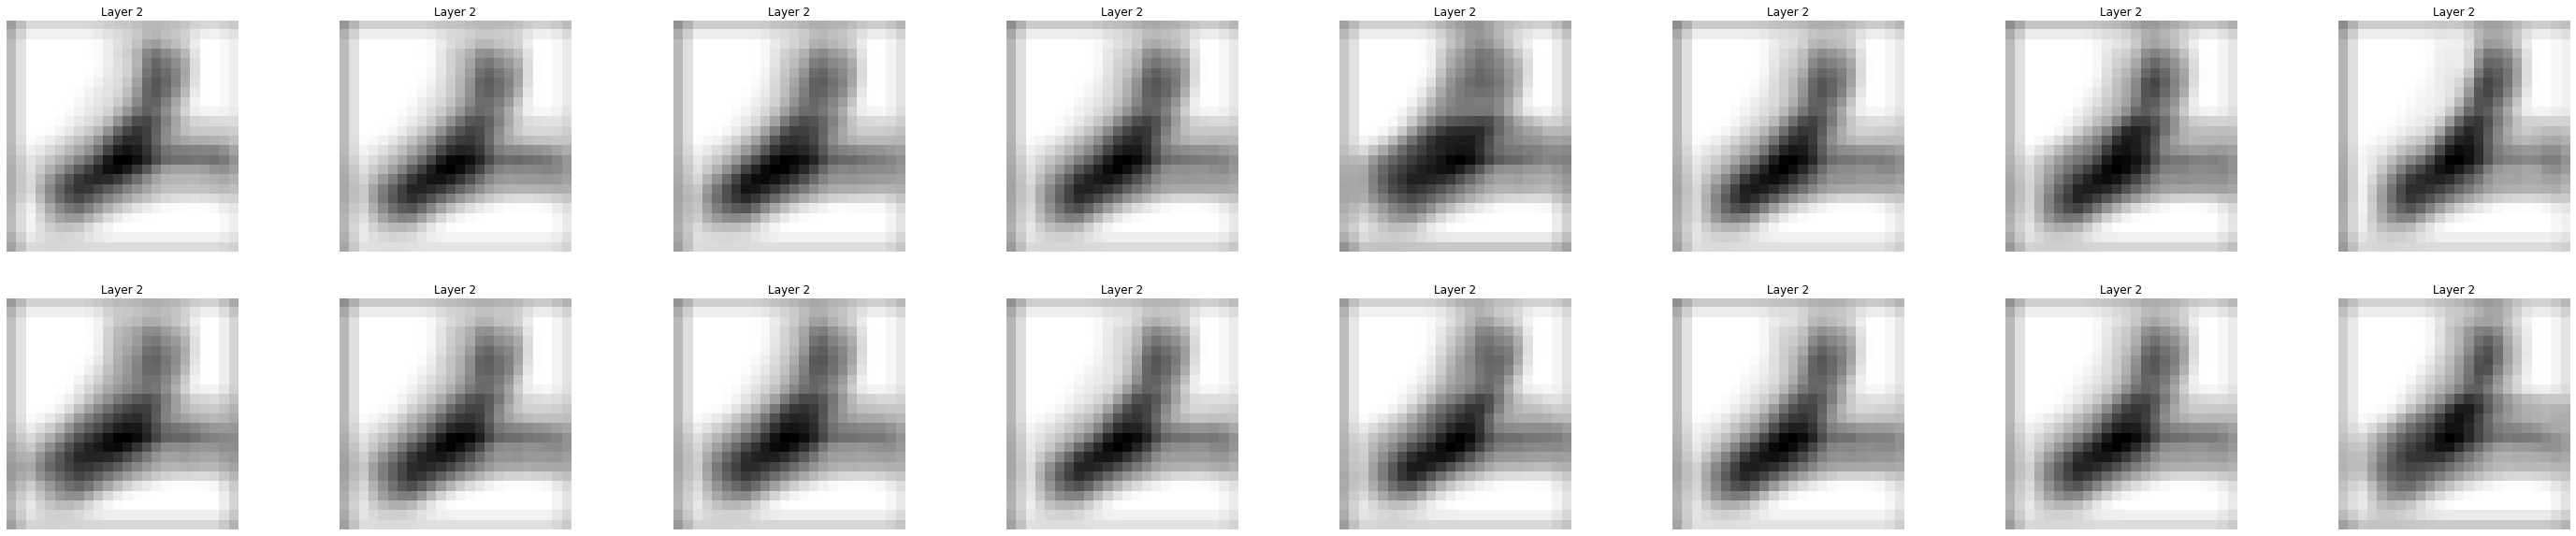

<Figure size 432x288 with 0 Axes>

In [19]:
gen_plot()